In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from random import choice

In [2]:
def para_tuning(name):
    """
    可视化对单一参数的调参，并保存图片
    :param name: 调整的参数名称字符串
    """
    the_scores = clf.cv_results_['mean_test_score']
    parameters = [x[name] for x in clf.cv_results_['params']]
    plt.figure(figsize=(10, 5))
    plt.plot(parameters, the_scores)
    plt.scatter(parameters, the_scores)
    plt.xlabel(name, fontsize=15)
    plt.ylabel('mean_test_score', fontsize=15)
    plt.xticks(parameters)
    plt.yticks(the_scores)
    plt.show()


def predict(model, valid_test_data):
    """
    利用模型model来对valid_test_data进行预测
    """
    y_predict_0 = model.predict_proba(valid_test_data.drop('id', axis=1)[important_feature_n])
    y_predict = pd.DataFrame(y_predict_0)[1]

    result_1 = pd.DataFrame({'id': valid_test_data['id'], 'prob': y_predict})
    result_2 = result_1[['id', 'prob']]

    if np.prod(valid_test_data['id'] == result_2['id']) != 1:
        print('error')

    return result_2

In [3]:
sample_train = pd.read_table("/home/dongf/open_data2/open_data/sample_train.txt")  # 训练集
valid_id = pd.read_table("/home/dongf/open_data2/open_data/valid_id.txt")  # 验证集
test_id = pd.read_table("/home/dongf/open_data2/open_data/test_id.txt")
data_reduced = pd.read_csv("/home/dongf/rong360_new/output/feature_engineer/data_reduced.csv")

label_cols = data_reduced.columns[[x.startswith('label') for x in data_reduced.columns]]

new_sample_data = pd.merge(sample_train, data_reduced.drop(label_cols, axis=1),
                           on='id', how='left')
new_valid_data = pd.merge(valid_id, data_reduced.drop(label_cols, axis=1),
                          on='id', how='left')
new_test_data = pd.merge(test_id, data_reduced.drop(label_cols, axis=1),
                          on='id', how='left')
# 对标签1过采样
# new_sample_data = new_sample_data.append(new_sample_data[new_sample_data['label'] == 1])

label = new_sample_data['label']
data = new_sample_data.drop(['id', 'label'], axis=1)

data_backup = data.copy()

In [4]:
params = {'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc',
          'seed': 0, 'silent': 1, 'min_child_weight': 3, 'max_depth': 4, 'subsample': 0.8,
          'colsample_bytree': 0.8, 'learning_rate': 0.04, 'lambda': 1.1,
          'n_estimators': 100}
xgb_model = xgb.XGBClassifier(**params)

# 2.下面进行根据特征重要性选出重要的特征

## 2.1 先选出重要特征：特征重要性大于0的

In [5]:
%%time
xgb_model.fit(data, label)

feature_importance = pd.DataFrame({'feature': data.columns, 'importance': xgb_model.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.reset_index(drop=True, inplace=True)

important_feature = feature_importance['feature'][feature_importance['importance'] > 0]

CPU times: user 1min 8s, sys: 88 ms, total: 1min 8s
Wall time: 1min 8s


# 4. 用不同数量的特征来进行调参

### 使用特征数为[90, 100, 110, 126, 160, 190, 246, 286]

In [187]:
important_feature_n = important_feature[:90]
data = data_backup[important_feature_n]

#### 先定义一个初始参数，然后定义好待调参数的范围

In [188]:
params = {'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc',
          'seed': 0, 'silent': 1, 'min_child_weight': 4, 'max_depth': 4, 'subsample': 0.8,
          'colsample_bytree': 0.8, 'learning_rate': 0.05, 'reg_lambda': 1,
          'n_estimators': 100, 'scale_pos_weight': 1}

In [189]:
def get_tune_params(x):
    if x == 'max_depth':
        the_tune_params = {'max_depth': [3, 4, 5, 6]}
    if x == 'min_child_weight':
        the_tune_params = {'min_child_weight': [3, 4, 5, 6]}
    if x == 'learning_rate':
        the_tune_params = {'learning_rate': np.linspace(0.03, 0.21, choice([8,9,10,11,12]))}
    if x == 'reg_lambda':
        the_tune_params = {'reg_lambda': np.linspace(0.5, 2, choice([8,9,10,11,12]))}
    if x == 'subsample':
        the_tune_params = {'subsample': np.linspace(0.65, 0.95, choice([8,9,10,11,12]))}
    if x == 'colsample_bytree':
        the_tune_params = {'colsample_bytree': np.linspace(0.65, 0.95, choice([8,9,10,11,12]))}
    if x == 'n_estimators':
        the_tune_params = {'n_estimators': list(range(100, 180, choice([3,4,5,6])))}
        
    return the_tune_params

## 1.对学习率进行调参

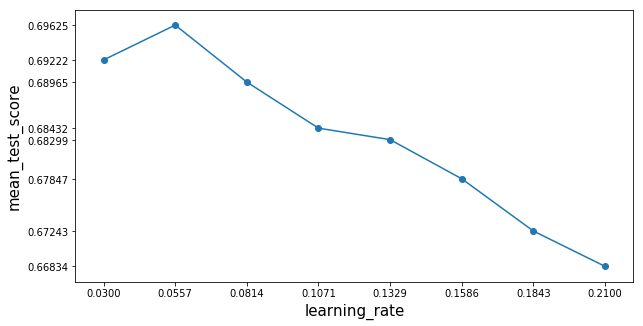

{'learning_rate': 0.055714285714285716}


In [230]:
param = 'learning_rate'
params.pop(param)

tune_params = get_tune_params(param)

xgboost = xgb.XGBClassifier(**params)
clf = GridSearchCV(xgboost, param_grid=tune_params, scoring="roc_auc", refit=False, n_jobs=24, cv=5)
clf.fit(data, label)
para_tuning(param)

params[param] = clf.best_params_[param]

del(param)
print(clf.best_params_)

## 2. 先对max_depth调参

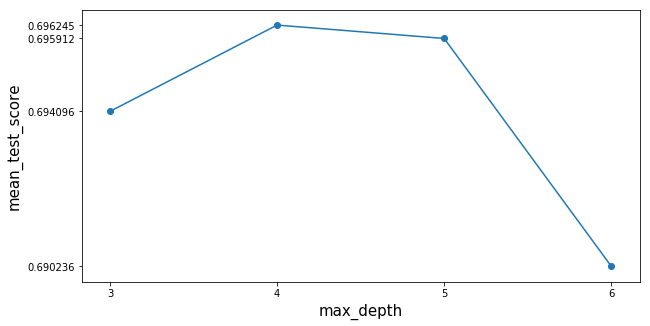

{'max_depth': 4}


In [231]:
param = 'max_depth'
params.pop(param)

tune_params = get_tune_params(param)

xgboost = xgb.XGBClassifier(**params)
clf = GridSearchCV(xgboost, param_grid=tune_params, scoring="roc_auc", refit=False, n_jobs=24, cv=5)
clf.fit(data, label)
para_tuning(param)

params[param] = clf.best_params_[param]

del(param)
print(clf.best_params_)

## 3, 对 min_child_weight 调参

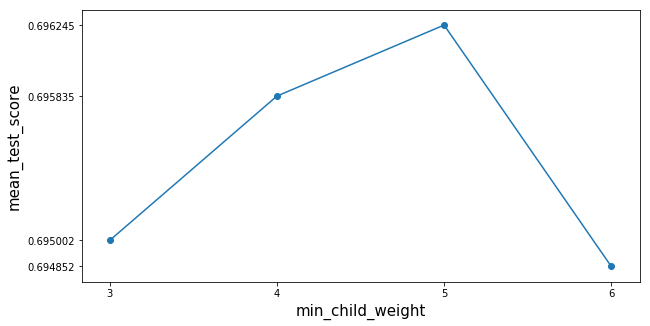

{'min_child_weight': 5}


In [232]:
param = 'min_child_weight'
params.pop(param)

tune_params = get_tune_params(param)

xgboost = xgb.XGBClassifier(**params)
clf = GridSearchCV(xgboost, param_grid=tune_params, scoring="roc_auc", refit=False, n_jobs=24, cv=5)
clf.fit(data, label)
para_tuning(param)

params[param] = clf.best_params_[param]

del(param)
print(clf.best_params_)

### 4.对L2正则系数进行调参

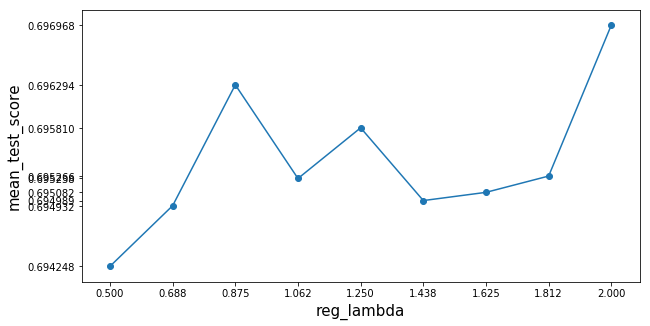

{'reg_lambda': 2.0}


In [233]:
param = 'reg_lambda'
params.pop(param)

tune_params = get_tune_params(param)

xgboost = xgb.XGBClassifier(**params)
clf = GridSearchCV(xgboost, param_grid=tune_params, scoring="roc_auc", refit=False, n_jobs=24, cv=5)
clf.fit(data, label)
para_tuning(param)

params[param] = clf.best_params_[param]

del(param)
print(clf.best_params_)

### 5.对subsample调参

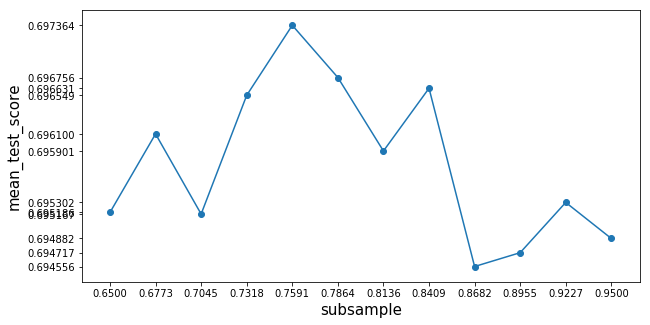

{'subsample': 0.759090909090909}


In [234]:
param = 'subsample'
params.pop(param)

tune_params = get_tune_params(param)

xgboost = xgb.XGBClassifier(**params)
clf = GridSearchCV(xgboost, param_grid=tune_params, scoring="roc_auc", refit=False, n_jobs=24, cv=5)
clf.fit(data, label)
para_tuning(param)

params[param] = clf.best_params_[param]

del(param)
print(clf.best_params_)

### 6.对colsample_bytree调参

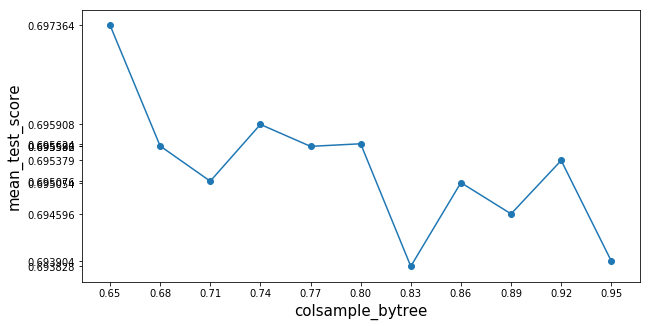

{'colsample_bytree': 0.65}


In [235]:
param = 'colsample_bytree'
params.pop(param)

tune_params = get_tune_params(param)

xgboost = xgb.XGBClassifier(**params)
clf = GridSearchCV(xgboost, param_grid=tune_params, scoring="roc_auc", refit=False, n_jobs=24, cv=5)
clf.fit(data, label)
para_tuning(param)

params[param] = clf.best_params_[param]

del(param)
print(clf.best_params_)

### 7.对n_estimators进行调参

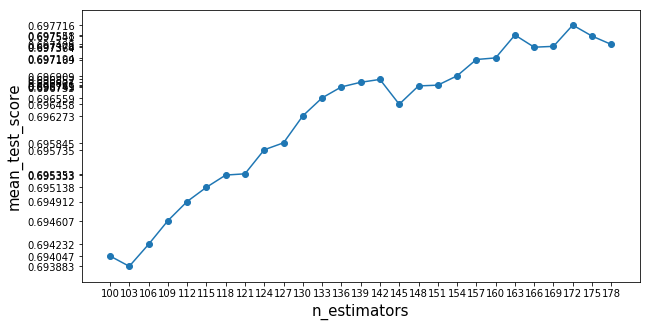

{'n_estimators': 172}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.65, eval_metric='auc', gamma=0,
       learning_rate=0.055714285714285716, max_delta_step=0, max_depth=4,
       min_child_weight=5, missing=None, n_estimators=172, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=2.0, scale_pos_weight=1, seed=0, silent=1,
       subsample=0.759090909090909)


In [236]:
param = 'n_estimators'
params.pop(param)

tune_params = get_tune_params(param)

xgboost = xgb.XGBClassifier(**params)
clf = GridSearchCV(xgboost, param_grid=tune_params, scoring="roc_auc", refit=True, n_jobs=24, cv=5)
clf.fit(data, label)
para_tuning(param)

params[param] = clf.best_params_[param]

del(param)
print(clf.best_params_)
print(clf.best_estimator_)

# 5.输出结果

In [237]:
xgb_model = clf.best_estimator_
xgb_model.fit(data, label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.65, eval_metric='auc', gamma=0,
       learning_rate=0.055714285714285716, max_delta_step=0, max_depth=4,
       min_child_weight=5, missing=None, n_estimators=172, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=2.0, scale_pos_weight=1, seed=0, silent=1,
       subsample=0.759090909090909)

In [238]:
result_valid = predict(xgb_model, new_valid_data)
result_test = predict(xgb_model, new_test_data)

In [239]:
scores = cross_val_score(xgb_model, data, label, cv=5, scoring='roc_auc', n_jobs=24)
mean_score = np.mean(scores)
print(mean_score)

result_valid.to_csv('/home/dongf/rong360_new/output/valid/result_%s_5_8.txt' % str(round(mean_score, 4)), index=False)
result_test.to_csv('/home/dongf/rong360_new/output/test/result_%s_5_8.txt' % str(round(mean_score, 4)), index=False)

0.697714356233154


# 下面是该调参过程的循环版本，可以直接运行，但是运行时间较长

## 实际上由于特征比较强，整个结果还是很稳健的，只需少量的调参都可以达到比较高的AUC，并且各种不同参数的xgboost的AUC都收敛到了0.7222, 所以调参应该是充分的，在给定特征的情况下，对于参数来说，应该达到了全局最优

In [ ]:
for n_feature in [90, 100, 110, 126, 160, 190, 246, 286]:
    params = {'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc',
              'seed': 0, 'silent': 1, 'min_child_weight': 3, 'max_depth': 4, 'subsample': 0.8,
              'colsample_bytree': 0.8, 'learning_rate': 0.04, 'reg_lambda': 1.1,
              'n_estimators': 100, 'scale_pos_weight': 1}
    important_feature_n = important_feature[:n_feature]
    data = data[important_feature_n]
    for iter in range(5):
        for param in ['max_depth', 'min_child_weight', 'learning_rate', 'reg_lambda', 
                      'subsample', 'colsample_bytree', 'n_estimators', 'scale_pos_weight']:
            params.pop(param)
            
            tune_params = get_tune_params(param)
            
            xgboost = xgb.XGBClassifier(**params)
            clf = GridSearchCV(xgboost, param_grid=tune_params, scoring="roc_auc", refit=True, n_jobs=20, cv=5)
            clf.fit(data, label)
            params[param] = clf.best_params_[param]
        
        xgb_model = clf.best_estimator_
        xgb_model.fit(data, label)
        
        scores = cross_val_score(xgb_model, data, label, cv=5, scoring='roc_auc', n_jobs=24)
        mean_score = np.mean(scores)
        print(mean_score)
        
        result_valid = predict(xgb_model, new_valid_data)
        result_test = predict(xgb_model, new_test_data)
        
        result_valid.to_csv('./output/valid/result_%s.txt' % str(round(mean_score, 4)), index=False)
        result_test.to_csv('./output/test/result_%s.txt' % str(round(mean_score, 4)), index=False)